In [8]:

from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN,Embedding, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime
from glob import glob
import random
import os


class Homework3:
    def __init__(self):
        self.LOSS = "categorical_crossentropy"
        self.OPTIMIZER = "adam"
        self.SEQUENCE_LENGTH = 300          # max number of words in each sentence
        self.EMBEDDING_SIZE = 300           # N-Dimensional GloVe embedding vectors
        self.N_WORDS = 10000                # number of words to use, discarding the rest
        self.OOV_TOKEN = None               # out of vocabulary token
        self.TEST_SIZE = 0.3                # 30% testing set, 70% training set

    def load_IMBD(self):
        # read reviews
        reviews = []
        with open("data/reviews.txt") as f:
            for review in f:
                review = review.strip()
                reviews.append(review)

        labels = []
        with open("data/labels.txt") as f:
            for label in f:
                label = label.strip()
                labels.append(label)
        # tokenize the dataset corpus, delete uncommon words such as names, etc.
        tokenizer = Tokenizer(num_words=self.N_WORDS, oov_token=self.OOV_TOKEN)
        tokenizer.fit_on_texts(reviews)
        X = tokenizer.texts_to_sequences(reviews)
        X, y = np.array(X), np.array(labels)
        # pad sequences with 0's
        X = pad_sequences(X, maxlen=self.SEQUENCE_LENGTH)
        # convert labels to one-hot encoded
        y = to_categorical(y)
        # split data to training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.TEST_SIZE, random_state=1)
        data = {}
        data["X_train"] = X_train
        data["X_test"]= X_test
        data["y_train"] = y_train
        data["y_test"] = y_test
        data["tokenizer"] = tokenizer
        data["int2label"] =  {0: "negative", 1: "positive"}
        data["label2int"] = {"negative": 0, "positive": 1}
        return data

    def embedding_vectors(self, word_index):
        embedding_matrix = np.zeros((len(word_index) + 1, self.EMBEDDING_SIZE))
        with open(f"data/glove.6B.{self.EMBEDDING_SIZE}d.txt", encoding="utf8") as f:
            for line in tqdm(f, "Reading GloVe"):
                values = line.split()
                # get the word as the first word in the line
                word = values[0]
                if word in word_index:
                    idx = word_index[word]
                    # get the vectors as the remaining values in the line
                    embedding_matrix[idx] = np.array(values[1:], dtype="float32")
        return embedding_matrix

    def rnn(self, word_index, units=128, n_layers=1, cell=LSTM, bidirectional=False,
                    dropout=0.3,
                    optimizer="adam",
                    output_length=2):
        """Constructs a RNN model given its parameters"""
        embedding_matrix = self.embedding_vectors(word_index)
        model = Sequential()
        # add the embedding layer
        model.add(Embedding(len(word_index) + 1,
                  self.EMBEDDING_SIZE,
                  weights=[embedding_matrix],
                  trainable=False,
                  input_length=self.SEQUENCE_LENGTH))
        for i in range(n_layers):
            if i == n_layers - 1:
                # last layer
                if bidirectional:
                    model.add(Bidirectional(cell(units, return_sequences=False)))
                else:
                    model.add(cell(units, return_sequences=False))
            else:
                # first layer or hidden layers
                if bidirectional:
                    model.add(Bidirectional(cell(units, return_sequences=True)))
                else:
                    model.add(cell(units, return_sequences=True))
            model.add(Dropout(dropout))
        model.add(Dense(output_length, activation="softmax"))
        # compile the model
        model.compile(optimizer=self.OPTIMIZER, loss=self.LOSS, metrics=["accuracy"])
        return model

    def save_results(self,results_file_name, rnn_type, num_layers, dropout,bidirectional,hidden_state,loss,accuracy):
        """
        This function create a csv file and save all results of the experiment.
        the header of csv will be rnn_type, num_layers, dropout,bidirectional,hidden_state,loss,accuracy
        """
        f = open(results_file_name, 'a')
        f.write(str(rnn_type)+","+str(num_layers)+","+str(dropout)+","+str(bidirectional)+","+str(hidden_state)+","+str(loss)+","+str(accuracy))
        f.write("\n")
        f.close()


#Experiment
Experiment=Homework3()

rnn_cells={"Vanilla":SimpleRNN,"LSTM":LSTM}

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print("start at:", dt_string)
results_file_name="results_"+dt_string+".csv"

# load the data
data = Experiment.load_IMBD()
EPOCHS = 10
for rnn_type in ["Vanilla","LSTM"]:
    for num_layers in [1, 2]:# number of CELL layers
        for dropout in [0, 0.4]:# dropout rate #0.4
            for bidirectional in [False, True]:# whether it's a bidirectional RNN
                for hidden_state in [20, 50, 100, 200, 500]: # number of units (RNN_CELL ,nodes) in each layer #hidden_states

                    #construct the model
                    model = Experiment.rnn(data["tokenizer"].word_index, units=hidden_state, n_layers=num_layers,
                                        cell=rnn_cells[rnn_type], bidirectional=bidirectional,
                                        dropout=dropout,
                                        output_length=data["y_train"][0].shape[0])
                    model.summary()

                    # start training
                    history = model.fit(data["X_train"], data["y_train"],
                                        batch_size=64,
                                        epochs=EPOCHS,
                                        validation_data=(data["X_test"], data["y_test"]),
                                        verbose=1)
                    # get the loss and accuracy
                    result = model.evaluate(data["X_test"], data["y_test"])
                    # extract those
                    loss = result[0]
                    accuracy = result[1]
                    print(f"[+] Accuracy: {accuracy*100:.2f}%")

                    #save the result
                    Experiment.save_results(results_file_name,rnn_type,num_layers,dropout,bidirectional,hidden_state,loss,accuracy)

                    # save the resulting model into 'results' folder
                    now = datetime.now()
                    dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
                    model_name="model_"+rnn_type+"_"+str(num_layers)+"_"+str(dropout)+"_"+str(bidirectional)+"_"+str(hidden_state)+"_"+dt_string
                    model.save(model_name+".h5")

                    print("Saving the model", model_name)


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Call pandas.set_option("display.max_rows", max_rows, "display.max_columns", max_cols) with both max_rows 
# and max_cols as None to set the maximum number of rows and columns to display to unlimited, allowing the 
# full DataFrame to be displayed when printed.

pd.set_option("display.max_rows", None, "display.max_columns", None)


results="/Users/cristovao/Devel/course_dlrl/result_homework3.csv"

results = pd.read_csv(results)



results.info()

results['dif']=results['Accuracy']-results['Loss']



r1=results.sort_values('Hidden state dimension')
r1=r1.sort_values('RNN CELL',ascending=False)
r1.style.bar(subset=['Loss'],  color=['#d65f5f']).bar(subset=['Accuracy'], color=['#5fba7d'])




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RNN CELL                 80 non-null     object 
 1   Number of hidden layers  80 non-null     int64  
 2   Dropout                  80 non-null     float64
 3   Bidirectional            80 non-null     bool   
 4   Hidden state dimension   80 non-null     int64  
 5   Loss                     80 non-null     float64
 6   Accuracy                 80 non-null     float64
dtypes: bool(1), float64(3), int64(2), object(1)
memory usage: 4.0+ KB


,RNN CELL,Number of hidden layers,Dropout,Bidirectional,Hidden state dimension,Loss,Accuracy,dif
79,Vanilla,2,0.400000,True,500,0.662924,0.607000,-0.055924
54,Vanilla,1,0.400000,False,500,0.644510,0.607267,-0.037243
73,Vanilla,2,0.400000,False,200,0.642606,0.637133,-0.005473
61,Vanilla,2,0.000000,False,50,0.588474,0.692267,0.103793
74,Vanilla,2,0.400000,False,500,0.693228,0.499733,-0.193495
69,Vanilla,2,0.000000,True,500,0.574098,0.703400,0.129302
66,Vanilla,2,0.000000,True,50,0.573369,0.722733,0.149364
46,Vanilla,1,0.000000,True,50,0.600522,0.663667,0.063144
77,Vanilla,2,0.400000,True,100,0.536642,0.752267,0.215625
42,Vanilla,1,0.000000,False,100,0.587768,0.682867,0.095099


In [23]:
r2=results[results['RNN CELL']=='Vanilla'].sort_values('Hidden state dimension')
r2.style.bar(subset=['Loss'],  color=['#d65f5f']).bar(subset=['Accuracy'], color=['#5fba7d'])

,RNN CELL,Number of hidden layers,Dropout,Bidirectional,Hidden state dimension,Loss,Accuracy,dif
40,Vanilla,1,0.000000,False,20,0.548635,0.732400,0.183765
70,Vanilla,2,0.400000,False,20,0.684496,0.564267,-0.120230
65,Vanilla,2,0.000000,True,20,0.581325,0.704667,0.123341
45,Vanilla,1,0.000000,True,20,0.542646,0.732600,0.189954
60,Vanilla,2,0.000000,False,20,0.604880,0.663933,0.059053
55,Vanilla,1,0.400000,True,20,0.617667,0.659533,0.041866
75,Vanilla,2,0.400000,True,20,0.579195,0.701467,0.122272
50,Vanilla,1,0.400000,False,20,0.674350,0.575867,-0.098484
66,Vanilla,2,0.000000,True,50,0.573369,0.722733,0.149364
61,Vanilla,2,0.000000,False,50,0.588474,0.692267,0.103793


In [ ]:
_____________________________ Model 11 ____________________________________
Epoch 1/10
110s 202ms/step - loss: 0.4973 - accuracy: 0.7593 - val_loss: 0.3876 - val_accuracy: 0.8355
Epoch 2/10
112s 204ms/step - loss: 0.3527 - accuracy: 0.8504 - val_loss: 0.3047 - val_accuracy: 0.8727
Epoch 3/10
108s 197ms/step - loss: 0.2914 - accuracy: 0.8806 - val_loss: 0.2685 - val_accuracy: 0.8884
Epoch 4/10
110s 202ms/step - loss: 0.2637 - accuracy: 0.8925 - val_loss: 0.2688 - val_accuracy: 0.8890
Epoch 5/10
106s 195ms/step - loss: 0.2419 - accuracy: 0.9020 - val_loss: 0.2707 - val_accuracy: 0.8875
Epoch 6/10
111s 204ms/step - loss: 0.2239 - accuracy: 0.9102 - val_loss: 0.2453 - val_accuracy: 0.8993
Epoch 7/10
108s 198ms/step - loss: 0.2072 - accuracy: 0.9186 - val_loss: 0.2450 - val_accuracy: 0.9011
Epoch 8/10
110s 202ms/step - loss: 0.1890 - accuracy: 0.9250 - val_loss: 0.2497 - val_accuracy: 0.9041
Epoch 9/10
104s 190ms/step - loss: 0.1723 - accuracy: 0.9339 - val_loss: 0.2534 - val_accuracy: 0.8984
Epoch 10/10
135s 247ms/step - loss: 0.1598 - accuracy: 0.9391 - val_loss: 0.2562 - val_accuracy: 0.9052

                
                

                
                
                
                
_____________________________ Model 25 ____________________________________
Epoch 1/10
266s 487ms/step - loss: 0.4952 - accuracy: 0.7614 - val_loss: 0.3900 - val_accuracy: 0.8299
Epoch 2/10
268s 490ms/step - loss: 0.3512 - accuracy: 0.8477 - val_loss: 0.3247 - val_accuracy: 0.8626
Epoch 3/10
252s 460ms/step - loss: 0.3101 - accuracy: 0.8686 - val_loss: 0.3094 - val_accuracy: 0.8743
Epoch 4/10
252s 460ms/step - loss: 0.2819 - accuracy: 0.8835 - val_loss: 0.2781 - val_accuracy: 0.8879
Epoch 5/10
244s 447ms/step - loss: 0.2537 - accuracy: 0.8940 - val_loss: 0.2612 - val_accuracy: 0.8935
Epoch 6/10
232s 424ms/step - loss: 0.2343 - accuracy: 0.9048 - val_loss: 0.2584 - val_accuracy: 0.8954
Epoch 7/10
247s 452ms/step - loss: 0.2157 - accuracy: 0.9119 - val_loss: 0.2626 - val_accuracy: 0.8927
Epoch 8/10
186s 340ms/step - loss: 0.2001 - accuracy: 0.9192 - val_loss: 0.2552 - val_accuracy: 0.9001
Epoch 9/10
164s 300ms/step - loss: 0.1844 - accuracy: 0.9280 - val_loss: 0.2728 - val_accuracy: 0.8940
Epoch 10/10
162s 297ms/step - loss: 0.1698 - accuracy: 0.9339 - val_loss: 0.2516 - val_accuracy: 0.8998            
                
                
_____________________________ Model 64 ____________________________________
Epoch 1/10
580s 1s/step - loss: 0.7044 - accuracy: 0.5407 - val_loss: 0.7173 - val_accuracy: 0.5007
Epoch 2/10
587s 1s/step - loss: 0.7009 - accuracy: 0.5120 - val_loss: 0.6986 - val_accuracy: 0.5299
Epoch 3/10
626s 1s/step - loss: 0.6729 - accuracy: 0.5823 - val_loss: 0.6572 - val_accuracy: 0.6247
Epoch 4/10
631s 1s/step - loss: 0.6896 - accuracy: 0.5455 - val_loss: 0.6803 - val_accuracy: 0.5671
Epoch 5/10
648s 1s/step - loss: 0.6860 - accuracy: 0.5561 - val_loss: 0.6818 - val_accuracy: 0.5663
Epoch 6/10
707s 1s/step - loss: 0.6882 - accuracy: 0.5505 - val_loss: 0.6969 - val_accuracy: 0.5022
Epoch 7/10
724s 1s/step - loss: 0.7048 - accuracy: 0.5039 - val_loss: 0.7198 - val_accuracy: 0.5090
Epoch 8/10
749s 1s/step - loss: 0.7014 - accuracy: 0.5077 - val_loss: 0.6922 - val_accuracy: 0.5105
Epoch 9/10
740s 1s/step - loss: 0.7024 - accuracy: 0.5065 - val_loss: 0.7051 - val_accuracy: 0.5109
Epoch 10/10
742s 1s/step - loss: 0.7052 - accuracy: 0.5012 - val_loss: 0.7432 - val_accuracy: 0.4998


_____________________________ Model 74 ____________________________________
Epoch 1/10
535s 977ms/step - loss: 0.8041 - accuracy: 0.5051 - val_loss: 0.6885 - val_accuracy: 0.5817
Epoch 2/10
540s 988ms/step - loss: 0.7091 - accuracy: 0.5181 - val_loss: 0.6846 - val_accuracy: 0.5047
Epoch 3/10
556s 1s/step - loss: 0.7001 - accuracy: 0.5357 - val_loss: 0.6986 - val_accuracy: 0.5004
Epoch 4/10
570s 1s/step - loss: 0.7030 - accuracy: 0.5163 - val_loss: 0.7145 - val_accuracy: 0.4996
Epoch 5/10
587s 1s/step - loss: 0.7099 - accuracy: 0.5037 - val_loss: 0.6884 - val_accuracy: 0.5561
Epoch 6/10
587s 1s/step - loss: 0.7075 - accuracy: 0.5150 - val_loss: 0.7019 - val_accuracy: 0.5004
Epoch 7/10
617s 1s/step - loss: 0.7070 - accuracy: 0.5064 - val_loss: 0.6949 - val_accuracy: 0.5004
Epoch 8/10
613s 1s/step - loss: 0.7099 - accuracy: 0.5042 - val_loss: 0.6988 - val_accuracy: 0.5004
Epoch 9/10
601s 1s/step - loss: 0.7068 - accuracy: 0.5033 - val_loss: 0.6935 - val_accuracy: 0.5004
Epoch 10/10
637s 1s/step - loss: 0.7088 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4997







,model,loss,accuracy,val_loss,val_accuracy
0,model_74,0.8041,0.5051,0.6885,0.5817
1,model_74,0.7091,0.5181,0.6846,0.5047
2,model_74,0.7001,0.5357,0.6986,0.5004
3,model_74,0.7030,0.5163,0.7145,0.4996
4,model_74,0.7099,0.5037,0.6884,0.5561
5,model_74,0.7075,0.5150,0.7019,0.5004
6,model_74,0.7070,0.5064,0.6949,0.5004
7,model_74,0.7099,0.5042,0.6988,0.5004
8,model_74,0.7068,0.5033,0.6935,0.5004
9,model_74,0.7088,0.5019,0.6932,0.4997


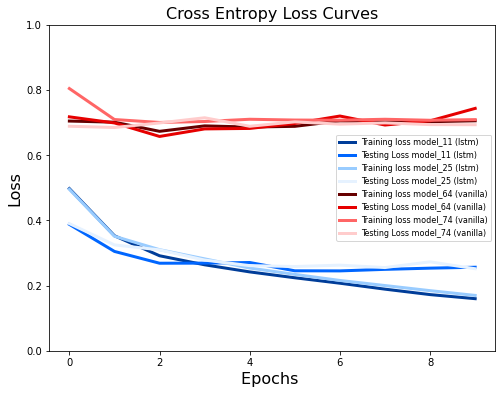

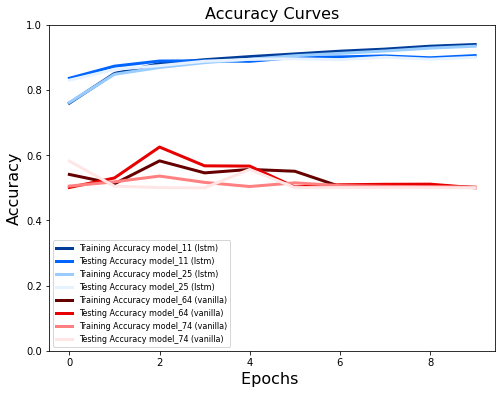

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Call pandas.set_option("display.max_rows", max_rows, "display.max_columns", max_cols) with both max_rows 
# and max_cols as None to set the maximum number of rows and columns to display to unlimited, allowing the 
# full DataFrame to be displayed when printed.

pd.set_option("display.max_rows", None, "display.max_columns", None)


results="/Users/cristovao/Devel/course_dlrl/models_cases_11_25_64_74.csv"

results = pd.read_csv("/Users/cristovao/Devel/course_dlrl/models_cases_74.csv")




# datatmp=dataset4[dataset4['Date'] >= "2020-03-13 09:00:00"] #& 
# df_20200313_0900=datatmp[datatmp['Date'] < "2020-03-13 09:01:00"]

results_model11=pd.read_csv("/Users/cristovao/Devel/course_dlrl/models_cases_11.csv")
results_model25=pd.read_csv("/Users/cristovao/Devel/course_dlrl/models_cases_25.csv")
results_model64=pd.read_csv("/Users/cristovao/Devel/course_dlrl/models_cases_64.csv")
results_model74=pd.read_csv("/Users/cristovao/Devel/course_dlrl/models_cases_74.csv")

plt.figure(figsize=[8,6])
plt.plot(results_model11['loss'],'#003d99', linewidth=3.0)
plt.plot(results_model11['val_loss'],'#0066ff',linewidth=3.0)
plt.plot(results_model25['loss'],'#99ccff', linewidth=3.0)
plt.plot(results_model25['val_loss'],'#e6f2ff',linewidth=3.0)
plt.plot(results_model64['loss'],'#660000', linewidth=3.0)
plt.plot(results_model64['val_loss'],'#e60000',linewidth=3.0)
plt.plot(results_model74['loss'],'#ff6666', linewidth=3.0)
plt.plot(results_model74['val_loss'],'#ffcccc',linewidth=3.0)
plt.legend(
    ['Training loss model_11 (lstm)', 'Testing Loss model_11 (lstm)',
     'Training loss model_25 (lstm)', 'Testing Loss model_25 (lstm)',
     'Training loss model_64 (vanilla)', 'Testing Loss model_64 (vanilla)',
     'Training loss model_74 (vanilla)', 'Testing Loss model_74 (vanilla)',
    ],fontsize=8)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Cross Entropy Loss Curves',fontsize=16)
#plt.xticks(range(epochs))
plt.ylim(0,1)
# plt.savefig(filename+'_Loss_Curves_fe.png')
#Plot the Accuracy Curves
plt.figure(figsize=[8,6]) 
plt.plot(results_model11['accuracy'],'#003d99', linewidth=3.0)
plt.plot(results_model11['val_accuracy'],'#0066ff',linewidth=3.0)
plt.plot(results_model25['accuracy'],'#99ccff', linewidth=3.0)
plt.plot(results_model25['val_accuracy'],'#e6f2ff',linewidth=3.0)
plt.plot(results_model64['accuracy'],'#660000', linewidth=3.0)
plt.plot(results_model64['val_accuracy'],'#e60000',linewidth=3.0)
plt.plot(results_model74['accuracy'],'#ff8080', linewidth=3.0)
plt.plot(results_model74['val_accuracy'],'#ffe6e6',linewidth=3.0)
plt.legend(
    ['Training Accuracy model_11 (lstm)', 'Testing Accuracy model_11 (lstm)',
     'Training Accuracy model_25 (lstm)', 'Testing Accuracy model_25 (lstm)',
     'Training Accuracy model_64 (vanilla)', 'Testing Accuracy model_64 (vanilla)',
     'Training Accuracy model_74 (vanilla)', 'Testing Accuracy model_74 (vanilla)',
    ],fontsize=8)
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 
plt.title('Accuracy Curves',fontsize=16)
#plt.xticks(range(epochs))
plt.ylim(0,1)
# plt.savefig(filename+'_Accuracy_Curves_fe.png')



results

